### 0. Period between data rows

In [15]:
df1 = df.sort_values('timestamp')
df1['dt_diff'] = df1.groupby('fkLinkSerialId').timestamp.diff().dt.total_seconds()
print(df1.shape)
df1[:2]

(323410, 50)


,pkId,fkLinkSerialId,timestamp,speed,heading,msla,lat,long,tsReceived,dt,sunrise,sunset,temperature,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,weatherid,place_type,accuracy,place_name,text,place,region,locality,neighborhood,postcode,country,timestamp_day,timestamp_month,ts_month,ts_hour,ts_season,ts_daypart,target_humidity,target_temperature,target_humidity_cat,target_temperature_cat,target_cat,lat_int,long_int,geo_group,fold,dt_diff
8125,2603778,0X0004BFD036AA,2022-05-09 00:50:19,0,0,70,45.60,-73.62,2022-05-09 00:50:19,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"10889 Avenue Arthur-Buies, Montréal, Quebec H1...",Avenue Arthur-Buies,Montréal,CA-QC,NaN,Montréal-Nord,H1G 6N3,ca,2022-05-09,2022-05,5,0,2,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,2,NaN
8127,2603780,0X0004BFD036AA,2022-05-09 00:50:37,0,0,62,45.60,-73.62,2022-05-09 00:50:37,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"5730 Boulevard Industriel, Montréal, Quebec H1...",Boulevard Industriel,Montréal,CA-QC,NaN,Montréal-Nord,H1G 4N6,ca,2022-05-09,2022-05,5,0,2,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,1,18.00


In [17]:
list_ids = df.fkLinkSerialId.unique()
list_colors = ['green','blue','orange']
list_ids

array(['0X0004BFD036AA', '0XB827EBF7489B', '0XB827EB3B7400'], dtype=object)

18.00   0.52
19.00   0.75
17.00   0.92
20.00   0.95
16.00   0.96
Name: dt_diff, dtype: float64
22.00   0.69
21.00   0.84
23.00   0.90
20.00   0.92
0.00    0.93
Name: dt_diff, dtype: float64
22.00   0.76
21.00   0.86
23.00   0.95
20.00   0.96
24.00   0.96
Name: dt_diff, dtype: float64


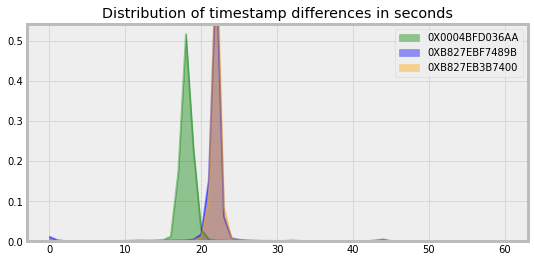

In [18]:
# histograms
for i,u in enumerate(list_ids):
    f1 = df1.fkLinkSerialId == u
    df2 = df1[f1].set_index('timestamp')[['dt_diff']]
    
    x = df2.dt_diff.value_counts(normalize = True)
    print(x.cumsum().iloc[:5])
    x.name = u
    _ = x.sort_index()[:60].plot(figsize = (8,4), kind = 'area', alpha = 0.4, color = list_colors[i], title = 'Distribution of timestamp differences in seconds', legend = True)


### 1. Data preprocessing

In [83]:
# data
filt = df_out.fkLinkSerialId == '0XB827EBF7489B'
feats_out = ['target_temperature_pred','target_humidity_pred']
df_ts = df_out[filt].set_index('timestamp')[feats_out].sort_index()
print(df_ts.shape)
df_ts[:3]

(130024, 2)


,target_temperature_pred,target_humidity_pred
timestamp,,
2022-05-09 07:06:25,14.53,67.60
2022-05-09 07:06:47,14.43,72.74
2022-05-09 07:07:09,14.23,66.47


In [84]:
# resample to 1 minute interval
df_ts = df_ts.resample('1min').median()
print(df_ts.shape)
df_ts[:3]

(499092, 2)


,target_temperature_pred,target_humidity_pred
timestamp,,
2022-05-09 07:06:00,14.48,70.17
2022-05-09 07:07:00,12.90,66.81
2022-05-09 07:08:00,13.31,66.91


In [144]:
# transform to the tensor for training NN
PERIODS_IN  = 10
PERIODS_OUT = 5

n = df_ts.shape[0]
n_pers = PERIODS_IN + PERIODS_OUT
feat = 'target_temperature_pred'

out1 = list()
out2 = list()
list_mean = list()
list_std = list()
for i1 in range(n - n_pers):
    i2 = i1 + PERIODS_IN
    i3 = i2 + PERIODS_OUT
    vals = df_ts[i1:i3][feat]
    if vals.isnull().any():
        continue
    m = vals.mean()
    s = vals.std()
    list_mean.append(m)
    list_std.append(s)
    vals = (vals - m) / s 
    if vals.isnull().any():
        continue
    out1.append(vals[:PERIODS_IN].values)
    out2.append(vals[-PERIODS_OUT:].values)

x_train = np.array(out1)
y_train = np.array(out2)

print(x_train.shape, y_train.shape)

(39130, 10) (39130, 5)


In [145]:
# shuffle (if needed)
ind = np.arange(0,len(x_train))
print(ind)

# np.random.shuffle(ind)
# x_train = x_train[ind]
# y_train = y_train[ind]
# ind

[    0     1     2 ... 39127 39128 39129]


### 2. Modeling

In [197]:
from keras import layers
from keras import models
from keras import Input
from tensorflow.keras import applications

# 1) Create model - MLP
model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', input_dim=PERIODS_IN))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu', input_dim=PERIODS_IN))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu', input_dim=PERIODS_IN))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', input_dim=PERIODS_IN))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='relu',))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(PERIODS_OUT, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_65 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_66 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 45        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


In [198]:
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks

# 2) compile model
model.compile(
    optimizer = optimizers.rmsprop_v2.RMSprop(lr=0.001),
    loss      = losses.mae,
    metrics   = ['mae']
)

In [199]:
# 3) train model
history = model.fit(
    x_train,
    y_train,
    epochs = 200,
    batch_size = 1024,
    validation_split = 0.25,
    callbacks = [],
    verbose = 0,
)

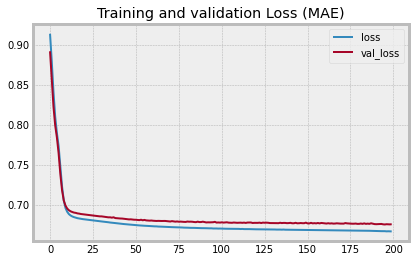

In [200]:
# 4) plotting
df_res = pd.DataFrame(history.history)
_,ax = plt.subplots(1,1,figsize = (6,4))
p = df_res.iloc[:,[0,2]].plot(ax = ax, title = 'Training and validation Loss (MAE)')

In [201]:
# Make predictions
st_std  = np.array(list_std)
st_mean = np.array(list_mean)

n = x_train.shape[0]
n1 = -int(0.25*n)

yv = y_train[n1:]*st_std[n1:,np.newaxis] + st_mean[n1:,np.newaxis]

yv_pred = model.predict(x_train[n1:])
yv_pred = yv_pred*st_std[n1:,np.newaxis] + st_mean[n1:,np.newaxis]

yv_last = x_train[n1:,-1]*st_std[n1:] + st_mean[n1:]

In [218]:
print(x_train[n1:].shape, y_train[n1:].shape)
print(x_train[:n1].shape, y_train[:n1].shape)

(9778, 10) (9778, 5)
(29334, 10) (29334, 5)


In [202]:
abs(yv - yv_pred).mean()

0.347068528948552

In [203]:
abs(yv - yv_last[:,np.newaxis]).mean()

0.4691980180135837